In [34]:
import numpy as np

N = 50

np.random.seed(0)

x_train = np.linspace(-3, 3, N)
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=N)

x_train = x_train.astype(np.float32).reshape((N, 1))
y_train = y_train.astype(np.float32).reshape((N, 1))

In [41]:
import tensorflow as tf

from edward.models import Normal

W_0 = Normal(loc=tf.zeros((1, 2)), scale=tf.ones((1, 2)))
W_1 = Normal(loc=tf.zeros((2, 1)), scale=tf.ones((2, 1)))
b_0 = Normal(loc=tf.zeros(2), scale=tf.ones(2))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

x = tf.placeholder(tf.float32, (N, 1))

layer_0 = tf.tanh(tf.matmul(x, W_0) + b_0)
mu = tf.matmul(layer_0, W_1) + b_1

y = Normal(loc=mu, scale=0.1)

In [43]:
qW_0 = Normal(loc=tf.Variable(tf.zeros((1, 2))),
              scale=tf.nn.softplus(tf.Variable(tf.zeros((1, 2)))))
qW_1 = Normal(loc=tf.Variable(tf.zeros((2, 1))),
              scale=tf.nn.softplus(tf.Variable(tf.zeros((2, 1)))))
qb_0 = Normal(loc=tf.Variable(tf.zeros(2)),
              scale=tf.nn.softplus(tf.Variable(tf.zeros(2))))
qb_1 = Normal(loc=tf.Variable(tf.zeros(1)),
              scale=tf.nn.softplus(tf.Variable(tf.zeros(1))))

In [79]:
import edward as ed

# Don't fully understand this... we are replacing the parameters in the
# original model with the 'q' prefixed variables??
dict_swap = {
    W_0: qW_0,
    b_0: qb_0,
    W_1: qW_1,
    b_1: qb_1}

inference = ed.KLqp(dict_swap, data={x: x_train, y: y_train})
inference.run(n_iter=1000)               

1000/1000 [100%] ██████████████████████████████ Elapsed: 5s | Loss: -10.579


In [80]:
# This step is critical for forming the posterior as a tensorflow
# variable
y_posterior = ed.copy(y, dict_swap)

In [82]:
ed.evaluate('mean_squared_error', data={x: x_train, y_posterior: y_train})

0.011908422

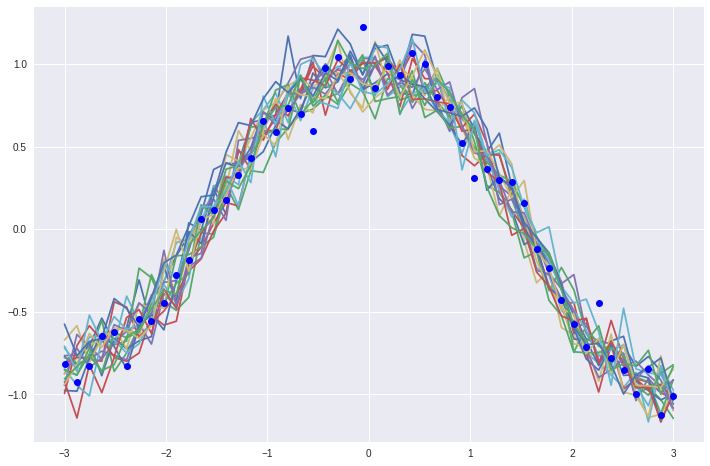

In [83]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 8))


sample_ys = [y_posterior.eval(feed_dict={x: x_train}) for _ in range(20)]
for sample_y in sample_ys:
    plt.plot(x_train, sample_y)
plt.plot(x_train, y_train, 'bo');